In [290]:
import deepchem as dc
import numpy as np
import tensorflow as tf
import os
from deepchem.data import Dataset, NumpyDataset
from typing import Any, Callable, Dict, Iterable, List, Optional, Sequence, Tuple, Union
from tensorflow.keras.layers import Input, Concatenate, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.python.keras import metrics
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from functools import partial

In [2]:
from IPython import display

In [3]:
tf.__version__

'2.2.0'

In [4]:
conda list deepchem

# packages in environment at c:\users\m.grabski\appdata\local\continuum\anaconda3\envs\deepchem:
Note: you may need to restart the kernel to use updated packages.

#
# Name                    Version                   Build  Channel
deepchem                  2.4.0rc1.dev20200803093024          pypi_0    pypi


In [223]:
#GENERATE DATAPOINTS 
n_classes = 4
class_centers = np.random.uniform(-4, 4, (n_classes, 3 ))
class_transforms = []
for i in range(n_classes):
    xscale = np.random.uniform(0.5, 2)
    yscale = np.random.uniform(0.5, 2)
    zscale = np.random.uniform(0.5, 2)
    angle = np.random.uniform(0, np.pi)
    m = [[xscale*np.cos(angle), -yscale*np.sin(angle), -zscale*np.sin(angle) ],
         [xscale*np.sin(angle), yscale*np.cos(angle), zscale*np.sin(angle)],
         [xscale*np.sin(angle), -yscale*np.cos(angle), zscale*np.sin(angle)]]
    class_transforms.append(m)
class_transforms = np.array(class_transforms)

def generate_data(n_points):
    classes = np.random.randint(n_classes, size=n_points)
    r = np.random.random(n_points)
    angle = 2*np.pi*np.random.random(n_points)
    phi = np.linspace(0, np.pi, n_points)
    points = (r*np.array([np.cos(angle), np.sin(angle), np.cos(phi)])).T
    points = np.einsum('ijk,ik->ij', class_transforms[classes], points)
    points += class_centers[classes]
    return classes, points

In [271]:
def generate_sets(n_classes, n_points):
    class_centers = np.random.uniform(-4, 4, (n_classes, 3 ))
    classes, points = [],[]
    for c in range(n_classes):
        center = class_centers[c]
        for p in range(n_points//n_classes):
            theta = np.random.uniform(0, np.pi)
            phi = np.random.uniform(0, 2*np.pi)
            #r = np.random.uniform()
            r= 1
            x = center[0] + (r * np.sin(theta) * np.cos(phi))
            y = center[1] + (r * np.sin(theta) * np.sin(phi))
            z = center[2] + (r * np.cos(theta))
            classes.append(c)
            points.append([x,y,z])
    return np.array(classes), np.array(points)

In [272]:
classes, points = generate_sets(4,300)

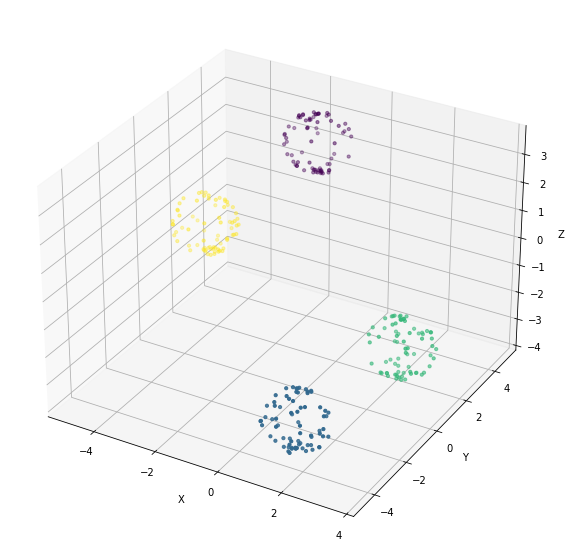

In [273]:
%matplotlib inline
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[:,0],points[:,1], points[:,2], c=classes, s=10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [274]:
dataset = dc.data.NumpyDataset(points,classes)

In [300]:
class WGAN(dc.models.KerasModel):
    
    def __init__(self,
                 batch_size: int = 100,
                 n_critic : int = 5,
                 gradient_penalty_weight : float = 10,
                 noise_dimensions : int = 10,
                 data_dimensions : int = 3,
                 plot_epoch_interval : int =100,
                 **kwargs):
        #batch size
        self.batch_size = batch_size
        #determines impact of the gradient penalty
        self.gradient_penalty_weight = gradient_penalty_weight
        #how many times critic is trained per generator
        self.n_critic = n_critic
        #noise input dimensions
        self.noise_dim  = noise_dimensions
        #critic input dimensions e.g. 2 = x,y, 3 = x,y,z
        self.dimensions = data_dimensions
        #option used for flexibility, used for class in this example
        self.conditionals = 1
        #every how many epochs graph should be updated
        self.plot_epoch_interval= plot_epoch_interval
        #used by critic model
        self.discriminator_input_dim = self.dimensions + self.conditionals
        #because critic uses binary classification
        self.discriminator_output_dim = 1
        #noise model input
        self.generator_input_dim = self.noise_dim
        #must equal disctriminator/critic input
        self.generator_output_dim = self.discriminator_input_dim

        self.generator_optimizer = self.create_generator_optimizer()
        self.discriminator_optimizer = self.create_discriminator_optimizer()

        self.generator = self.create_generator()
        self.discriminator = self.create_discriminator()
        
        self.generator.compile(optimizer=self.generator_optimizer)
        self.discriminator.compile(optimizer=self.discriminator_optimizer)


        #create sample noise, can be omitted, currently used for displaying graph
        self.noise = self.generate_noise()
        
        #use for counting epochs during fit
        self._epoch = 0
        self._global_step=tf.Variable(0, trainable=False)
        self._c_losses = []
        self._g_losses = []
        self._checkpoint = {'generator': tf.train.Checkpoint(optimizer=self.generator_optimizer, model=self.generator),
                           'discriminator': tf.train.Checkpoint(optimizer=self.discriminator_optimizer, model=self.discriminator)}

        
        super(WGAN, self).__init__(self.generator, None, **kwargs)
        
        self.optimizer = {'generator': self.generator_optimizer, 'discriminator': self.discriminator_optimizer}
        
        
    def create_discriminator(self) -> tf.keras.Model:
        """Creates discriminator/critic model
        
        Returns
        -------
        discriminator/critic model
        """
        model = Sequential()
        model.add(Dense(25,  kernel_initializer='he_uniform', input_dim=self.discriminator_input_dim))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(15,  kernel_initializer='he_uniform'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(10,  kernel_initializer='he_uniform'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(5,  kernel_initializer='he_uniform'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(self.discriminator_output_dim))
        return model
    
    def create_generator(self) -> tf.keras.Model:
        """Creates generator model
        
        Returns
        -------
        generator model
        """
        model = Sequential()
        model.add(Dense(30, kernel_initializer='he_uniform', input_dim=self.generator_input_dim))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(15,  kernel_initializer='he_uniform'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(10,  kernel_initializer='he_uniform'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(self.generator_output_dim))
        return model

    def create_generator_optimizer(self, learning_rate=1e-4):
        """Create optimizer for generator
        
        Returns
        -------
        Optimizer used in generator model
        """
        return tf.keras.optimizers.Adam(learning_rate = learning_rate)

    def create_discriminator_optimizer(self,learning_rate=1e-4 ):
        """Create optimizer for discriminator/critic
        
        Returns
        -------
        Optimizer used in discriminator/critic model
        """
        return tf.keras.optimizers.Adam(learning_rate = learning_rate)   

    @tf.function
    def generate_noise(self, count = None) -> tf.Tensor:
        """Generate noise input for generator
        Parameters
        ----------
        count: int
            how many points should be generated, if None it will use batch size instead
        
        Returns
        -------
        Tensor containing random normal noise with shape equal to (batch_size, noise dimensions)
        """
        
        if count == None:
            count = self.batch_size
            
        return tf.random.normal([count, self.noise_dim])

    @tf.function
    def train_generator(self) -> float:
        """Train generator on single batch of noise data
        
        Returns
        -------
        loss of critic on data generated by the generator
        """
        #generate noise input data
        noise = self.generate_noise()

        with tf.GradientTape() as tape:
            #generate fake data
            fake = self.generator(noise, training=True)
            #check how well discriminator predicts fake data
            logits = self.discriminator(fake, training=False)
            loss = -tf.reduce_mean(logits)

        #update gradients
        gradients = tape.gradient(loss,self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
        return loss

    @tf.function
    def train_discriminator(self,
                            X: Sequence,
                            y: Sequence) -> float:
        """Train discriminator/critic on data
        
        Parameters
        ----------
        X: ndarray
            the real data input
        y: ndarray
            data conditionals i.e. classes or properties used on top of input data
            
        Returns
        -------
        loss"""
        #generate batch of random noise
        noise = self.generate_noise()
        #check if there are any conditional inputs e.g. classes
        if self.conditionals>0:
            #check if shape is correct, otherwise tf.concat will fail
            if y.shape is not (self.batch_size,self.conditionals):
                y = tf.reshape(y, (self.batch_size,self.conditionals))
            #combine inputs
            X = tf.concat([X, y], axis=1)
            
        #training block       
        with tf.GradientTape() as tape:
            fake = self.generator(noise, training=False)
            fake_logits = self.discriminator(fake, training=True)
            real_logits = self.discriminator(X, training=True)
            fake_loss = tf.reduce_mean(fake_logits)
            real_loss = tf.reduce_mean(real_logits)
            cost = fake_loss - real_loss
            penalty = self.gradient_penalty(partial(self.discriminator, training=True), X, fake)
            cost += self.gradient_penalty_weight * penalty
        gradients = tape.gradient(cost, self.discriminator.trainable_variables)
        self.discriminator_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
        return cost

    @tf.function
    def gradient_penalty(self,
                         func: partial,
                         real: Sequence,
                         fake: Sequence):
        """loss calculated for discriminator aka critic
        
        Parameters
        ----------
        func: partial
            partial function, substitute for self.discriminator
        real: ndarray
            real input data
        fake:
            data obtained from the generator
            
        Returns
        -------
        Gradient penalty used during training of discriminator"""

        alpha = tf.random.uniform([self.batch_size, self.discriminator_input_dim], 0.0, 1.0)
        difference = fake - real
        internal_sample = real + (alpha * difference)
        with tf.GradientTape() as tape:
            tape.watch(internal_sample)
            predicted_sample = func(internal_sample)
        gradient = tape.gradient(predicted_sample, [internal_sample])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradient), axis=[1]))
        penalty = tf.reduce_mean((slopes - 1.)**2)
        return penalty
    
    @tf.function
    def _prepare_batch(self, batch):
        X = tf.convert_to_tensor(batch[0][0])
        y = tf.convert_to_tensor(batch[1])
        
        if X.dtype is not 'float32':
            X = tf.cast(X,'float32')
            
        if y.dtype is not 'float32':
            y = tf.cast(y, 'float32')

        return X,y
    
       
    def fit(self,
          dataset: Dataset,
          nb_epoch: int = 1,
          verbose: int = 0) -> Tuple[float, float]:
        """Train critic and generator for number of epochs
        
        Parameters
        ----------
        dataset: Dataset
            the Dataset to train on
        nb_epoch: int
            the number of epochs to train for
        verbose: int
            0 - no progress report, 1 - bar, 2 - history plot, 3 - graph, 4 - history plot + graph
        Returns
        -------
        critic loss and generator loss for the last epoch"""
        
        #reset epoch count
        self._epoch = 0
        
        #loss metrics
        g_loss = tf.metrics.Mean()
        c_loss = tf.metrics.Mean()
        critic_loss, generator_loss =  None, None 
        #epoch dependent functionality
        count = dataset.X.shape[0]
        batch_per_epoch = np.ceil(count/self.batch_size).astype('int32')
        total_batches = batch_per_epoch * nb_epoch
        #get batches
        data_generator = self.default_generator(dataset, epochs=nb_epoch)
        
        #train GAN
        for counter, batch in enumerate(data_generator):
            X,y = self._prepare_batch(batch)
            cl,gl = self.fit_on_batch(X,y)
            #loss across batches
            c_loss(cl)
            g_loss(gl)
            
            #controls what happens during each epoch, independent to training
            if counter % batch_per_epoch == 0:
                self._epoch = counter // batch_per_epoch
                
                #loss for current epoch
                critic_loss = c_loss.result().numpy()
                generator_loss = g_loss.result().numpy()
                #reset loss metrics
                g_loss.reset_states()
                c_loss.reset_states()
                self._c_losses.append(critic_loss)
                self._g_losses.append(generator_loss)
                
                #REPORTING PART
                if verbose == 1:
                    #simple reporting bar
                    total = 100
                    current = np.ceil((counter / total_batches) * total).astype('int32')
                    to_do = "-" * (total-current)
                    bar = ("#" * current) + to_do  + ' Progress: ' + str(current) + '%' 
                    display.clear_output(wait=True)
                    display.display(bar)
                #plot history progress
                elif verbose == 2:
                    if self._epoch > 0:
                        self._plot_history()
                #plot data graph
                elif verbose == 3:
                    if self._epoch % self.plot_epoch_interval == 0:
                        self._plot_graph(dataset)
                #plot combine history and data graph plots
                elif verbose == 4:
                    if self._epoch > 0 and self._epoch % self.plot_epoch_interval == 0:
                        self._plot_combined(dataset)
        return critic_loss, generator_loss
    
           
               
    @tf.function
    def fit_on_batch(self,
                     X: Sequence,
                     y: Sequence) -> Tuple[float, float]:
        """Performs single round of tranining (n_critic x discriminator followed by single generator)
        Parameters
        ----------
        X: ndarray
            the batch inputs
        y: ndarray
            the batch conditionals
        Returns
        -------
        mean critic loss and generator loss on the batch
        """
        losses = []
        for _ in range(self.n_critic):
            losses.append(self.train_discriminator(X, y))
        g_loss = self.train_generator()
        
        #assign global training step
        self._global_step.assign_add(1)
        
        return tf.reduce_mean(losses), g_loss
       
    def generate(self,
                 count: int) -> Sequence:
        """ Generate data on trained generator model
        
        Parameters
        ----------
        count: int
            How many datapoints should be generated
            
        Returns
        -------
            ndarray containing generated data"""
        noise = self.generate_noise(count=count)
        return self.generator(noise, training=False).numpy()
    
    
    def save_checkpoint(self,
        max_checkpoints_to_keep: int = 5,
        model_dir: Optional[str] = None) -> None:
        """Save a checkpoint to disk.
        
        Parameters
        ----------
        max_checkpoints_to_keep: int
            the maximum number of checkpoints to keep.  Older checkpoints are discarded.
        model_dir: str, default None
            Model directory to save checkpoint to. If None, revert to self.model_dir
        """
        if model_dir is None:
            model_dir = self.model_dir
            
        discriminator = os.path.join(model_dir, 'critic')
        if not os.path.exists(discriminator):
            os.makedirs(discriminator) 
            
        generator = os.path.join(model_dir, 'generator')
        if not os.path.exists(generator):
            os.makedirs(generator)
            
        #discriminator
        manager = tf.train.CheckpointManager(self._checkpoint['discriminator'], discriminator, max_checkpoints_to_keep)
        manager.save()
        #generator
        manager = tf.train.CheckpointManager(self._checkpoint['generator'], generator, max_checkpoints_to_keep)
        manager.save()
        
    def save(self, path: Optional[str] = None) -> Tuple[str,str]:
        """Save generator and discriminator to disk. Each model is saved individually into corresponding sub-folder called critic and generator.
        
        Parameters
        ----------
        path: str
            Path to top-folder under which critic and discriminator will be saved
        
        Returns
        -------
        path to discriminator folder and path to generator folder
        """
        if path is None:
            path = self.model_dir
        
        discriminator = os.path.join(path, 'critic')
        if not os.path.exists(discriminator):
            os.makedirs(discriminator) 
            
        generator = os.path.join(path, 'generator')
        if not os.path.exists(discriminator):
            os.makedirs(discriminator)
        
        self.generator.save(generator)
        self.discriminator.save(discriminator)
        
        return discriminator, generator
    
        
    def load(self, path: Optional[str] = None):
        """Load generator and discriminator from disk. Each model is loaded individually from corresponding sub-folder called critic and generator.
        Optimizers are also loaded in the process as well.
        
        Parameters
        ----------
        path: str
            Path to top-folder from which critic and discriminator folders will be loaded
        
        """
        if path is None:
            path = self.model_dir
        
        discriminator = os.path.join(path, 'critic')
        if not os.path.exists(discriminator):
            raise ValueError('discriminator folder not found.\n {}'.format(discriminator))
            
        generator = os.path.join(path, 'generator')
        if not os.path.exists(generator):
            raise ValueError('generator folder not found.\n {}'.format(generator))
        
        self.generator = tf.keras.models.load_model(generator)
        self.discriminator = tf.keras.models.load_model(discriminator)
            
        
   
    def _plot_graph(self, dataset):
        generated = self.generator(self.noise, training=False)

        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(dataset.X[:,0],dataset.X[:,1], dataset.X[:,2], c=dataset.y, alpha=0.2, s=10)
        ax.scatter(generated[:,0],generated[:,1], generated[:,2], c=[tf.math.round(x) for x in generated[:,3]], s=10, label='Epoch:{}'.format(self._epoch))               
        plt.legend(bbox_to_anchor=(0.7, 1.0), loc='upper left')
        plt.savefig('images/image_at_epoch_{:04d}.png'.format(self._epoch))
        
        display.clear_output(wait=True)
        display.display(plt.show())
        
    def _plot_history(self):
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        x = range(self._epoch+1)
        ax.plot(x, self._c_losses, c='red', label='critic loss')
        ax.plot(x, self._g_losses, c='blue', label='generator loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        display.clear_output(wait=True)
        display.display(plt.show())
        
    def _plot_combined(self,dataset):
        
        generated = self.generator(self.noise, training=False)
        
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(121)
        x = range(self._epoch+1)
        ax.plot(x, self._c_losses, c='red', label='critic loss')
        ax.plot(x, self._g_losses, c='blue', label='generator loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        plt.legend()
        ax = fig.add_subplot(122, projection='3d')
        ax.scatter(dataset.X[:,0],dataset.X[:,1], dataset.X[:,2], c=dataset.y, alpha=0.5, s=10)
        ax.scatter(generated[:,0],generated[:,1], generated[:,2], c=[tf.math.round(x) for x in generated[:,3]], s=10, label='Epoch:{}'.format(self._epoch))               
        plt.legend(bbox_to_anchor=(0.7, 1.0), loc='upper left')
        #plt.savefig('images/image_at_epoch_{:04d}.png'.format(self._epoch))
        display.clear_output(wait=True)
        display.display(plt.show())
        
        
    def predict(self):
        raise NotImplementedError("Predict functionality is not implemented, to generate new data use generate instead.")
    def fit_generator(self):
        raise NotImplementedError("Not implemented")
    def restore(self):
        raise NotImplementedError("Not implemented")
    def load_from_pretrained(self):
        raise NotImplementedError("Not implemented")

In [301]:
tf.keras.backend.clear_session()
g = WGAN(model_dir='C:/Users/m.grabski/Desktop/Sygnature AI/DeepChem testing/models')

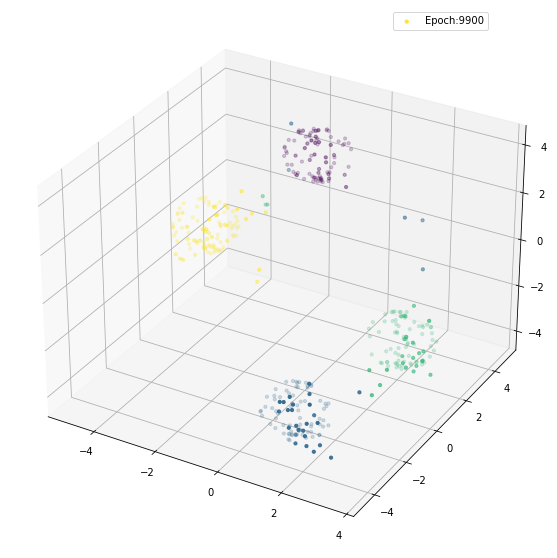

None

(0.09011959, -3.4172184)

In [302]:
g.fit(dataset,10000,verbose=3)

In [303]:
#IT WILL CREATE ANIMATED GIF OUT OF THE SAVED IMAGES
import imageio
import glob
anim_file = 'wgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('images/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)